In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu

# Load datasets
path_num = "rmpCapstoneNum.csv"
path_qual = "rmpCapstoneQual.csv"

# read datasets without headers (titles)
data_num = pd.read_csv(path_num, header=None)
data_qual = pd.read_csv(path_qual, header=None)

# create column names
data_num.columns = ["ave_rating", "ave_difficulty", "num_ratings", "pepper", "prop_take_again", "num_online_ratings", "male", "female"]
data_qual.columns = ["major", "university", "state"]

# combine datasets (same rows)
data = pd.concat([data_num, data_qual], axis=1)

# handle missing data:
# 1. If a row has too much missing data (more than 50%), simply dropping it
threshhold = data.shape[1]*0.5
data = data.dropna(thresh=threshhold)

# 2. Numerical columns: Fill missing values with the median
numerical_cols = ["ave_rating", "ave_difficulty", "num_ratings", "prop_take_again", "num_online_ratings"]
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

Q1: Whether there is gender bias (pro-male) in ratings?
U-Statistic: 346129258.5000
P-value: 4.2736e-06
Reject the null hypothesis: There is evidence of pro-male gender bias in the ratings.


C:\Users\Jerry Kang\AppData\Local\Temp\ipykernel_19944\3760757711.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["gender"] = filtered_data["male"].apply(lambda x: "Male" if x == 1 else "Female")
C:\Users\Jerry Kang\AppData\Local\Temp\ipykernel_19944\3760757711.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="gender", y="ave_rating", data=filtered_data, palette="Set2")


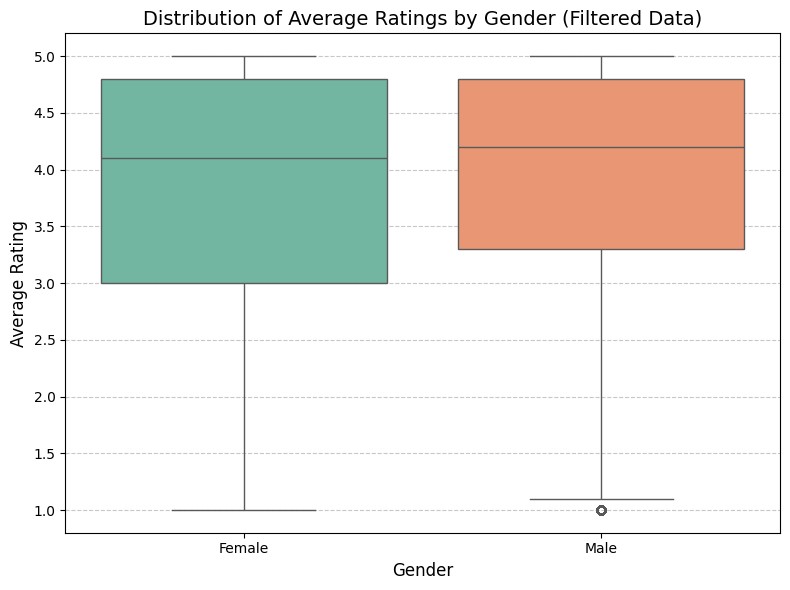

In [141]:
# Q1: Whether there is gender bias (pro-male) in ratings?
print("Q1: Whether there is gender bias (pro-male) in ratings?")

# Filter data: Remove rows where both male and female are 0 or both are 1
filtered_data = data[(data["male"] + data["female"] == 1)]

# Split the filtered data by gender
M_ratings = filtered_data[filtered_data["male"] == 1]["ave_rating"]
F_ratings = filtered_data[filtered_data["female"] == 1]["ave_rating"]

# Perform Mann-Whitney U Test (one-tailed: male ratings > female ratings)
u_stat, p_value = mannwhitneyu(M_ratings, F_ratings, alternative="greater")

# Print results
print(f"U-Statistic: {u_stat:.4f}")
print(f"P-value: {p_value:.4e}")

# Interpret the result
alpha = 0.005  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is evidence of pro-male gender bias in the ratings.")
else:
    print("Fail to reject the null hypothesis: No evidence of pro-male gender bias in the ratings.")

# Add a gender column for visualization
filtered_data["gender"] = filtered_data["male"].apply(lambda x: "Male" if x == 1 else "Female")

# Boxplot to visualize the distribution of ratings by gender
plt.figure(figsize=(8, 6))
sns.boxplot(x="gender", y="ave_rating", data=filtered_data, palette="Set2")
plt.title("Distribution of Average Ratings by Gender (Filtered Data)", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()




Q2: Is there an effect of experience on the quality of teaching?
Use median as threshold: 3.0
Mann-Whitney U-Test Results:
U-statistic: 648292604.5000
P-value: 2.5415e-52
Reject the null hypothesis: Experience has a significant effect on teaching quality.
Professors with higher experience tend to receive higher ratings.


C:\Users\Jerry Kang\AppData\Local\Temp\ipykernel_19944\303771834.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([low_experience, high_experience], labels=["Low Experience", "High Experience"], patch_artist=True)


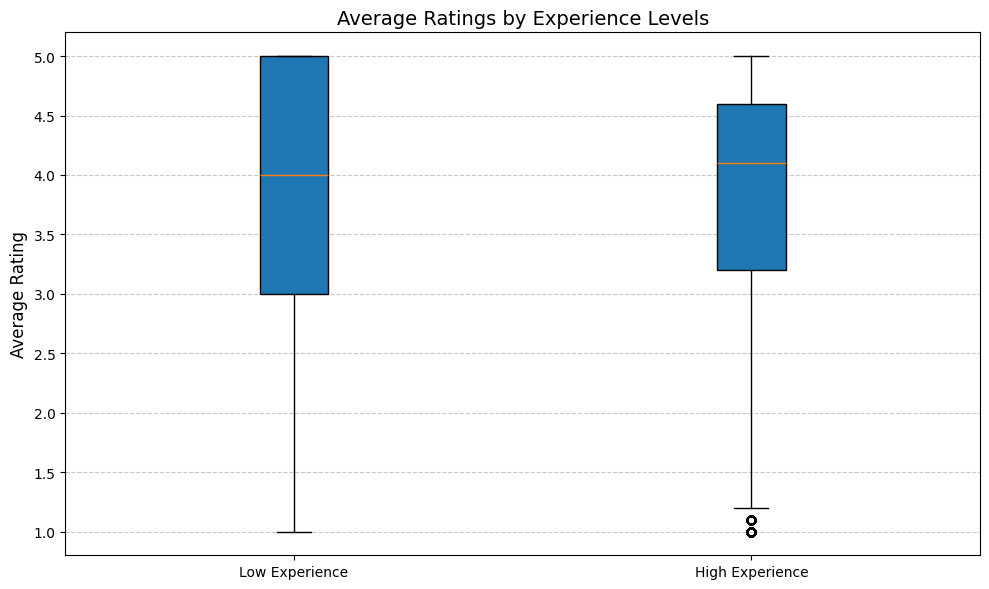

In [142]:
# Q2: Is there an effect of experience on the quality of teaching?
print("\nQ2: Is there an effect of experience on the quality of teaching?")
# Define experience groups using a threshold (median of num_ratings)
median_num_ratings = data["num_ratings"].median()
print(f"Use median as threshold: {median_num_ratings:.1f}")
low_experience = data[data["num_ratings"] <= median_num_ratings]["ave_rating"]
high_experience = data[data["num_ratings"] > median_num_ratings]["ave_rating"]

# Perform Mann-Whitney U-Test (two-tailed)
u_stat, p_value = mannwhitneyu(low_experience, high_experience, alternative="two-sided")

# Print Mann-Whitney U-Test results
print(f"Mann-Whitney U-Test Results:")
print(f"U-statistic: {u_stat:.4f}")
print(f"P-value: {p_value:.4e}")

# Explain the result
alpha = 0.005  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: Experience has a significant effect on teaching quality.")
    if low_experience.median() < high_experience.median():
        print("Professors with higher experience tend to receive higher ratings.")
    else:
        print("Professors with higher experience tend to receive lower ratings.")
else:
    print("Fail to reject the null hypothesis: No significant effect of experience on teaching quality.")

# Plot the distributions for visualization
plt.figure(figsize=(10, 6))
plt.boxplot([low_experience, high_experience], labels=["Low Experience", "High Experience"], patch_artist=True)
plt.title("Average Ratings by Experience Levels", fontsize=14)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



Q3: To determine the relationship between average rating (ave_rating) and average difficulty (ave_difficulty).


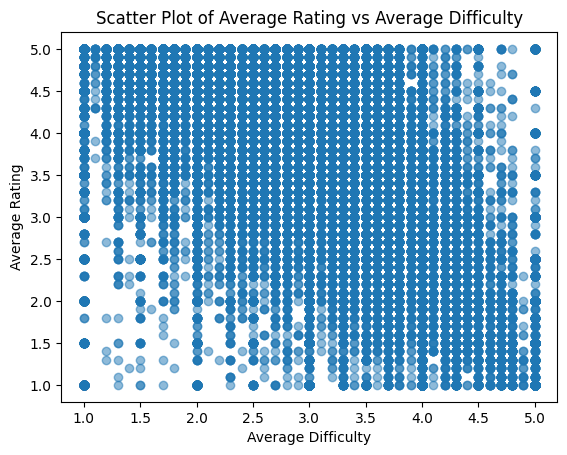

Spearman Correlation Coefficient: -0.5114


In [143]:
# Q3: To determine the relationship between average rating (ave_rating) and average difficulty (ave_difficulty).
# Before performing linear regression, plot a scatter plot to see the relationship between two variables
print("\nQ3: To determine the relationship between average rating (ave_rating) and average difficulty (ave_difficulty).")
# Scatter plot
plt.scatter(data["ave_difficulty"], data["ave_rating"], alpha=0.5)
plt.xlabel("Average Difficulty")
plt.ylabel("Average Rating")
plt.title("Scatter Plot of Average Rating vs Average Difficulty")
plt.show()

# the scatter plot does not appear strictly linear, but shows monotonic relationship.

# Perform Spearman correlation (for monotonic)
correlation, p_value = spearmanr(data["ave_difficulty"], data["ave_rating"])

print(f"Spearman Correlation Coefficient: {correlation:.4f}")

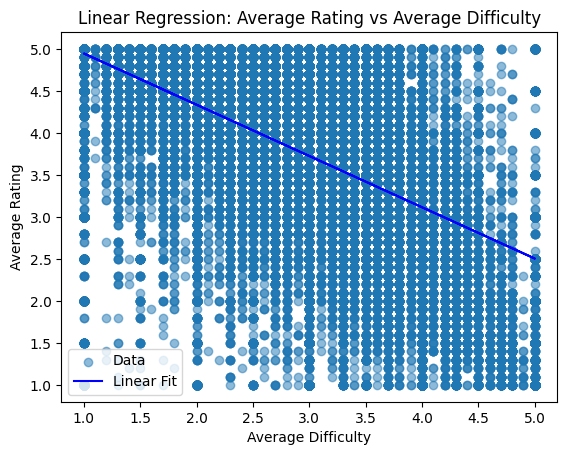


Linear Regression Results:
Intercept (β0): 5.5564
Slope (β1): -0.6103
R-squared: 0.2881


In [144]:
# --- Linear Regression ---
from sklearn.linear_model import LinearRegression
# Prepare data for regression (linear)
X = data[["ave_difficulty"]]  # Independent variable
y = data["ave_rating"]      # Dependent variable

# If it shows linear
model = LinearRegression()
model.fit(X, y)

# Predict for linear regression
y_linear_pred = model.predict(X)

# Plot linear regression
plt.scatter(X, y, alpha=0.5, label="Data")
plt.plot(X, y_linear_pred, color="blue", label="Linear Fit")
plt.xlabel("Average Difficulty")
plt.ylabel("Average Rating")
plt.title("Linear Regression: Average Rating vs Average Difficulty")
plt.legend()
plt.show()

# Get results (under linear regression)
slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)

# Print model coefficients (under linear regression)
print(f"\nLinear Regression Results:")
print(f"Intercept (β0): {intercept:.4f}")
print(f"Slope (β1): {slope:.4f}")
print(f"R-squared: {r2:.4f}")



Q4: Do professors who teach a lot of classes in the online modality receive higher or lower ratings than those who dont't?

Descriptive Statistics for 'num_online_ratings':
count    70004.000000
mean         0.315611
std          1.054728
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         19.000000
Name: num_online_ratings, dtype: float64


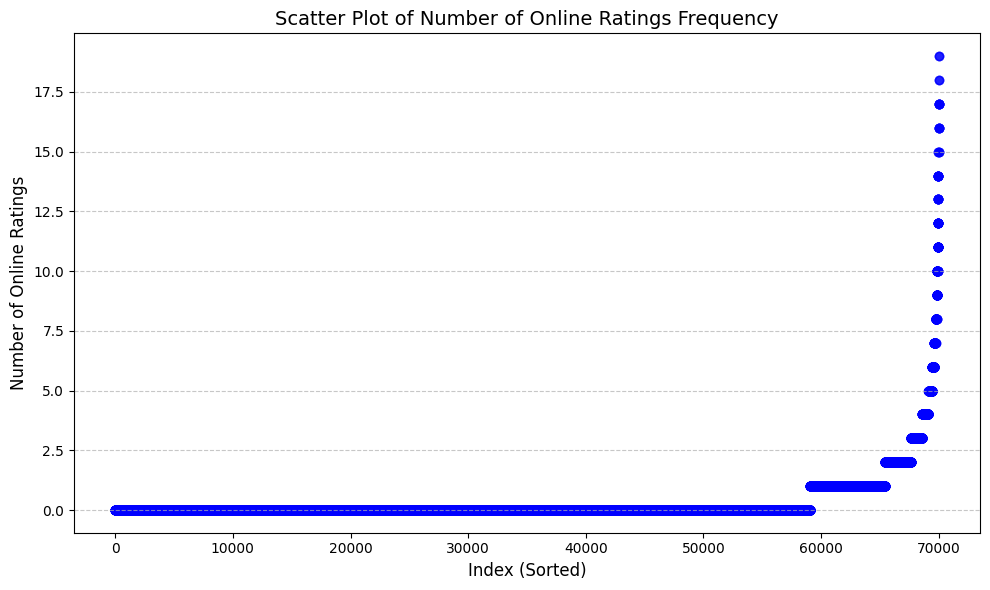

The median of 'num_online_ratings' is: 0.0
The smallest number for the top 5% of 'num_online_ratings' is: 2.00


In [145]:
# Q4: Do professors who teach a lot of classes in the online modality receive higher or lower ratings than those who don't?
print("\nQ4: Do professors who teach a lot of classes in the online modality receive higher or lower ratings than those who dont't?")

# Descriptive statistics for "num_online_ratings"
num_online_ratings_stats = data["num_online_ratings"].describe()

# Print descriptive statistics
print("\nDescriptive Statistics for 'num_online_ratings':")
print(num_online_ratings_stats)

# Scatter plot to show the frequency distribution of "num_online_ratings"
plt.figure(figsize=(10, 6))
plt.scatter(range(len(data["num_online_ratings"])), data["num_online_ratings"].sort_values(), alpha=0.5, color='blue')
plt.title("Scatter Plot of Number of Online Ratings Frequency", fontsize=14)
plt.xlabel("Index (Sorted)", fontsize=12)
plt.ylabel("Number of Online Ratings", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate the median of "num_online_ratings"
median_num_online_ratings = data["num_online_ratings"].median()

# Print the median
print(f"The median of 'num_online_ratings' is: {median_num_online_ratings}")

# Calculate the threshold for the top 5% of "num_online_ratings"
top_5_percentile = data["num_online_ratings"].quantile(0.95)

# Print the smallest number for the top 5%
print(f"The smallest number for the top 5% of 'num_online_ratings' is: {top_5_percentile:.2f}")

# Split the data into two groups
data["online_group"] = data["num_online_ratings"].apply(
    lambda x: "Teaches a Lot of Online Classes" if x >= top_5_percentile else "Teaches Few Online Classes")

group_high_online = data[data["online_group"] == "Teaches a Lot of Online Classes"]["ave_rating"]
group_low_online = data[data["online_group"] == "Teaches Few Online Classes"]["ave_rating"]


Mann-Whitney U-Test Results:
U-Statistic: 131753289.0000
P-value: 1.8794e-42
Reject the null hypothesis: There is a significant difference in ratings between the two groups.
Professors who teach a lot of online classes tend to receive lower ratings.


C:\Users\Jerry Kang\AppData\Local\Temp\ipykernel_19944\2607671090.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="online_group", y="ave_rating", data=data, palette="Set2")


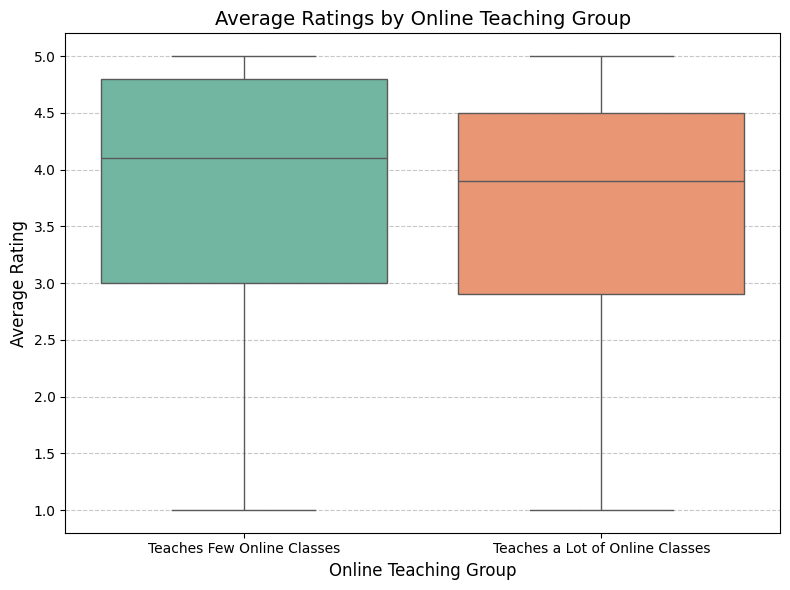

In [146]:
# Since we do not know if the data is normally distributed or not and the data is imbalance
# Perform Mann-Whitney U-Test (two-tailed), it is non-parametric test and does not assume equal sample sizes or normality
u_stat, p_value = mannwhitneyu(group_high_online, group_low_online, alternative="two-sided")

# Print the results
print(f"Mann-Whitney U-Test Results:")
print(f"U-Statistic: {u_stat:.4f}")
print(f"P-value: {p_value:.4e}")

# Interpret the results
alpha = 0.005  # Significance level
# Calculate the medians for both groups
median_high_online = group_high_online.median()
median_low_online = group_low_online.median()

# Compare medians and draw conclusions
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in ratings between the two groups.")
    if median_high_online > median_low_online:
        print("Professors who teach a lot of online classes tend to receive higher ratings.")
    elif median_high_online < median_low_online:
        print("Professors who teach a lot of online classes tend to receive lower ratings.")
    else:
        print("Medians are equal despite statistical significance.")
else:
    print("Fail to reject the null hypothesis: No significant difference in ratings between the two groups.")
    print("The medians suggest no substantial trend in ratings between the groups.")

# Step 4: Visualize the comparison with a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="online_group", y="ave_rating", data=data, palette="Set2")
plt.title("Average Ratings by Online Teaching Group", fontsize=14)
plt.xlabel("Online Teaching Group", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


Q5: Find the relationship between average rating and proportion of people who would take the class again.
Summary of Cleaned Data:
         ave_rating  prop_take_again
count  70004.000000     70004.000000
mean       3.808014         0.818565
std        1.126895         0.107181
min        1.000000         0.040000
25%        3.000000         0.830000
50%        4.000000         0.830000
75%        4.800000         0.830000
max        5.000000         1.000000


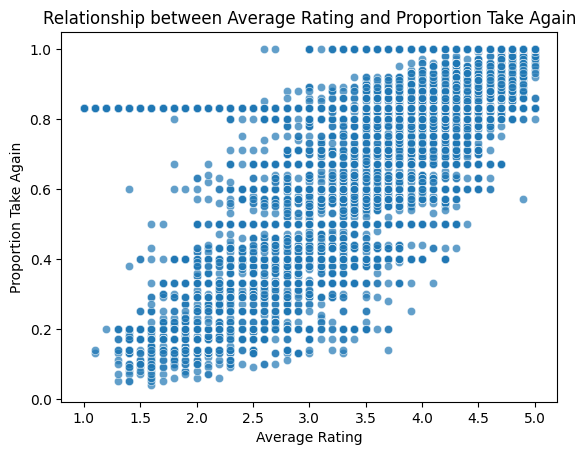

In [147]:
# Q5: Find the relationship between average rating and proportion of people who would take the class again.
print("\nQ5: Find the relationship between average rating and proportion of people who would take the class again.")

# Convert non-proportional values in 'prop_take_again' to proportions
data["prop_take_again"] = data["prop_take_again"].apply(lambda x: x / 100 if x > 1 else x)

# Data description
print("Summary of Cleaned Data:")
print(data[["ave_rating", "prop_take_again"]].describe())

# Visualize the Relationship
sns.scatterplot(x=data["ave_rating"], y=data["prop_take_again"], alpha=0.7)
plt.title("Relationship between Average Rating and Proportion Take Again")
plt.xlabel("Average Rating")
plt.ylabel("Proportion Take Again")
plt.show()

In [148]:
# Since the scatter plot shows a clear monotonic relationship
# Calculate Spearman Correlation
x = data["ave_rating"]
y = data["prop_take_again"]

corr, _ = spearmanr(x, y)
print("\nUsing Spearman Correlation:")
print(f"Correlation Coefficient (r): {corr:.4f}")

# Step 6: Describe the Relationship
if corr > 0:
    print("There is a positive relationship: as average ratings increase, the proportion of students willing to take the class again also increases.")
elif corr < 0:
    print("There is a negative relationship: as average ratings increase, the proportion of students willing to take the class again decreases.")
else:
    print("There is no relationship between average ratings and the proportion of students willing to take the class again.")


Using Spearman Correlation:
Correlation Coefficient (r): 0.2574
There is a positive relationship: as average ratings increase, the proportion of students willing to take the class again also increases.



Q6: Do professors who are 'hot' receive higher ratings than those who are not?
Mann-Whitney U-Test Results:
U-Statistic: 684243055.5000, P-Value: 0.0000e+00
Effect Size (r): 0.6927
There is a statistically significant difference between the two groups.
Hot professors receive higher ratings than those who are not hot.


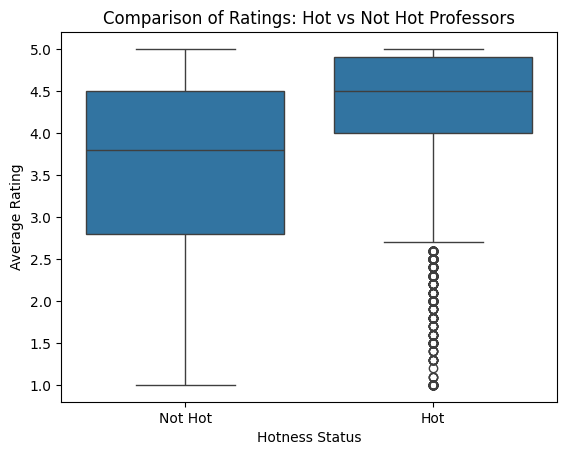

In [149]:
# Q6: Do professors who are "hot" receive higher ratings than those who are not?
print("\nQ6: Do professors who are 'hot' receive higher ratings than those who are not?")

# Split the Data (two independent groups)
group_hot = data[data["pepper"] == 1]["ave_rating"]  # Professors who are "hot"
group_not_hot = data[data["pepper"] == 0]["ave_rating"]  # Professors who are not "hot"

# Since we are not sure about the normality of data, we perform Mann-Whitney U-Test
u_stat, p_value = mannwhitneyu(group_hot, group_not_hot, alternative="two-sided")

# Calculate Effect Size
n1 = len(group_hot)
n2 = len(group_not_hot)
r = u_stat / (n1 * n2)

# Display Results
print("Mann-Whitney U-Test Results:")
print(f"U-Statistic: {u_stat:.4f}, P-Value: {p_value:.4e}")
print(f"Effect Size (r): {r:.4f}")

alpha = 0.005
if p_value < alpha:
    print("There is a statistically significant difference between the two groups.")
    if group_hot.median() > group_not_hot.median():
        print("Hot professors receive higher ratings than those who are not hot.")
    else:
        print("Hot professors receive lower ratings than those who are not hot.")
else:
    print("There is no statistically significant difference between the two groups.")

# Visualize the Results
sns.boxplot(x=data["pepper"].map({0: "Not Hot", 1: "Hot"}), y=data["ave_rating"])
plt.xlabel("Hotness Status")
plt.ylabel("Average Rating")
plt.title("Comparison of Ratings: Hot vs Not Hot Professors")
plt.show()


Q7: Build a regression model predicting average rating from difficulty.
Linear Regression Model (Train-Test Split):
Intercept (β0): 5.5593
Coefficient (β1): -0.6114

Training Performance:
R^2 (Train): 0.2889
RMSE (Train): 0.9507

Testing Performance:
R^2 (Test): 0.2849
RMSE (Test): 0.9511


c:\Users\Jerry Kang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Jerry Kang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


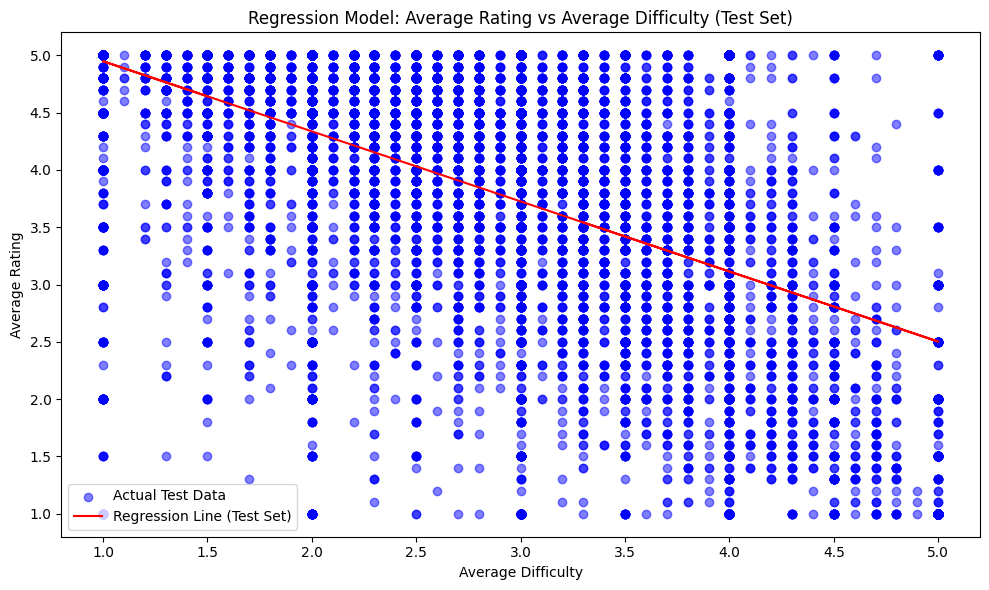

In [150]:
# Q7: Build a regression model predicting average rating from difficulty.
print("\nQ7: Build a regression model predicting average rating from difficulty.")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the Data
X = data["ave_difficulty"].values.reshape(-1, 1)  # Independent Variable
y = data["ave_rating"].values  # Dependent Variable

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12428625)

# Fit the Model on Training Data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on Training and Test Data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the Model
# Training Performance
r2_train = r2_score(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Testing Performance
r2_test = r2_score(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Print Results
print("Linear Regression Model (Train-Test Split):")
print(f"Intercept (β0): {model.intercept_:.4f}")
print(f"Coefficient (β1): {model.coef_[0]:.4f}")
print("\nTraining Performance:")
print(f"R^2 (Train): {r2_train:.4f}")
print(f"RMSE (Train): {rmse_train:.4f}")
print("\nTesting Performance:")
print(f"R^2 (Test): {r2_test:.4f}")
print(f"RMSE (Test): {rmse_test:.4f}")

# Visualize the Results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, alpha=0.5, color="blue", label="Actual Test Data")
plt.plot(X_test, y_test_pred, color="red", label="Regression Line (Test Set)")
plt.xlabel("Average Difficulty")
plt.ylabel("Average Rating")
plt.title("Regression Model: Average Rating vs Average Difficulty (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()



# Q8: Build a regression model predicting average rating using all available factors, and compare it to the 'difficulty only' model.

Ridge Regression Model (Train-Test Split):
Alpha (Regularization Strength): 0.1

Ridge Regression Coefficients:
ave_difficulty: -0.5477
num_ratings: 0.0034
prop_take_again: 1.5435
num_online_ratings: -0.0224
pepper: 0.5449
male: 0.0533
Coefficients: [-0.54771257  0.00343446  1.54348687 -0.02236517  0.54490124  0.05329159]

Training Performance:
R^2 (Train): 0.3697
RMSE (Train): 0.8862

Testing Performance:
R^2 (Test): 0.3470
RMSE (Test): 0.8971


c:\Users\Jerry Kang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Jerry Kang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


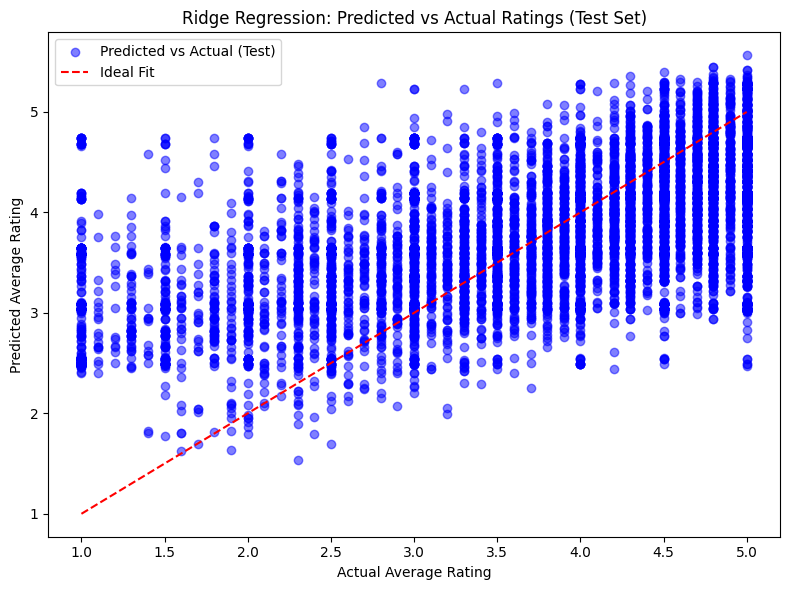

In [151]:
# Q8: Build a regression model predicting average rating using all available factors, and compare it to the "difficulty only" model.
print("\n# Q8: Build a regression model predicting average rating using all available factors, and compare it to the 'difficulty only' model.")
from sklearn.linear_model import RidgeCV

# Filter Data
# Drop rows with NaN values in binary categories
data_dropna_binary = data.dropna(subset=["male", "female", "pepper"])

# Filter rows where only one of 'male' or 'female' is 1
filtered_data = data_dropna_binary[(data_dropna_binary["male"] + data_dropna_binary["female"] == 1)]

# Drop one of the collinear columns ('female'), keeping 'male' to represent gender
filtered_data = filtered_data.drop(columns=["female"])

# Prepare the Data
predictors = ["ave_difficulty", "num_ratings", "pepper", "prop_take_again", "num_online_ratings", "male"]
X = filtered_data[predictors]  # Independent variables
y = filtered_data["ave_rating"]  # Dependent variable

# Identify binary columns (already 0/1) that don't need transformation
binary_columns = ["pepper", "male"]

# Apply get_dummies only to non-binary columns
X_transformed = pd.get_dummies(X.drop(columns=binary_columns), drop_first=True)

# Add binary columns back to the transformed dataset
X_final = pd.concat([X_transformed, X[binary_columns]], axis=1)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=12428625)

# Step 4: Ridge Regression
ridge = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0, 1000.0), cv=5)  # Cross-validation to select the best alpha
ridge.fit(X_train, y_train)

# Get Coefficients
selected_features = X_train.columns  # Ridge includes all features
coefficients = ridge.coef_

# Evaluate the Model
# Predict and Evaluate on Training Data
y_pred_train = ridge.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)  # R^2 for training
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)  # RMSE for training

# Predict and Evaluate on Test Data
y_pred_test = ridge.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)  # R^2 for testing
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)  # RMSE for testing

# Print Results
print("\nRidge Regression Model (Train-Test Split):")
print(f"Alpha (Regularization Strength): {ridge.alpha_}")
# Print Coefficients with Feature Names
print("\nRidge Regression Coefficients:")
for feature, coef in zip(selected_features, coefficients):
    print(f"{feature}: {coef:.4f}")
print(f"Coefficients: {coefficients}")
print("\nTraining Performance:")
print(f"R^2 (Train): {r2_train:.4f}")
print(f"RMSE (Train): {rmse_train:.4f}")
print("\nTesting Performance:")
print(f"R^2 (Test): {r2_test:.4f}")
print(f"RMSE (Test): {rmse_test:.4f}")

# Visualize Predicted vs Actual for the Test Set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue', label='Predicted vs Actual (Test)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Average Rating')
plt.ylabel('Predicted Average Rating')
plt.title('Ridge Regression: Predicted vs Actual Ratings (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()


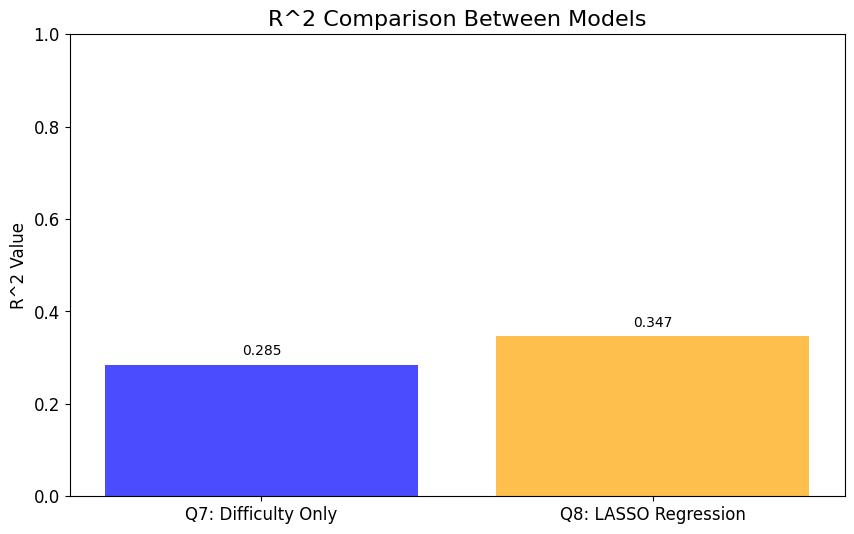

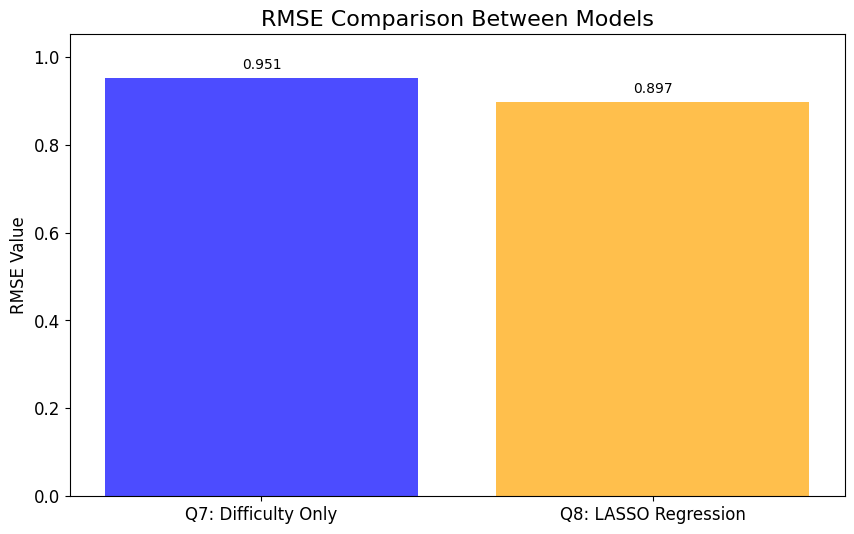

In [152]:
# Compare results between two models (Q8 and Q7)
# Data (for test set)
models = ["Q7: Difficulty Only", "Q8: LASSO Regression"]
r2_values = [0.2849, 0.3470]  # R^2 for Q7 and Q8
rmse_values = [0.9511, 0.8971]  # RMSE for Q7 and Q8

# Plot R^2 comparison
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color=['blue', 'orange'], alpha=0.7)
plt.title("R^2 Comparison Between Models", fontsize=16)
plt.ylabel("R^2 Value", fontsize=12)
plt.ylim(0, 1)
plt.text(0, r2_values[0] + 0.02, f"{r2_values[0]:.3f}", ha='center', fontsize=10, color='black')
plt.text(1, r2_values[1] + 0.02, f"{r2_values[1]:.3f}", ha='center', fontsize=10, color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'orange'], alpha=0.7)
plt.title("RMSE Comparison Between Models", fontsize=16)
plt.ylabel("RMSE Value", fontsize=12)
plt.ylim(0, max(rmse_values) + 0.1)
plt.text(0, rmse_values[0] + 0.02, f"{rmse_values[0]:.3f}", ha='center', fontsize=10, color='black')
plt.text(1, rmse_values[1] + 0.02, f"{rmse_values[1]:.3f}", ha='center', fontsize=10, color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


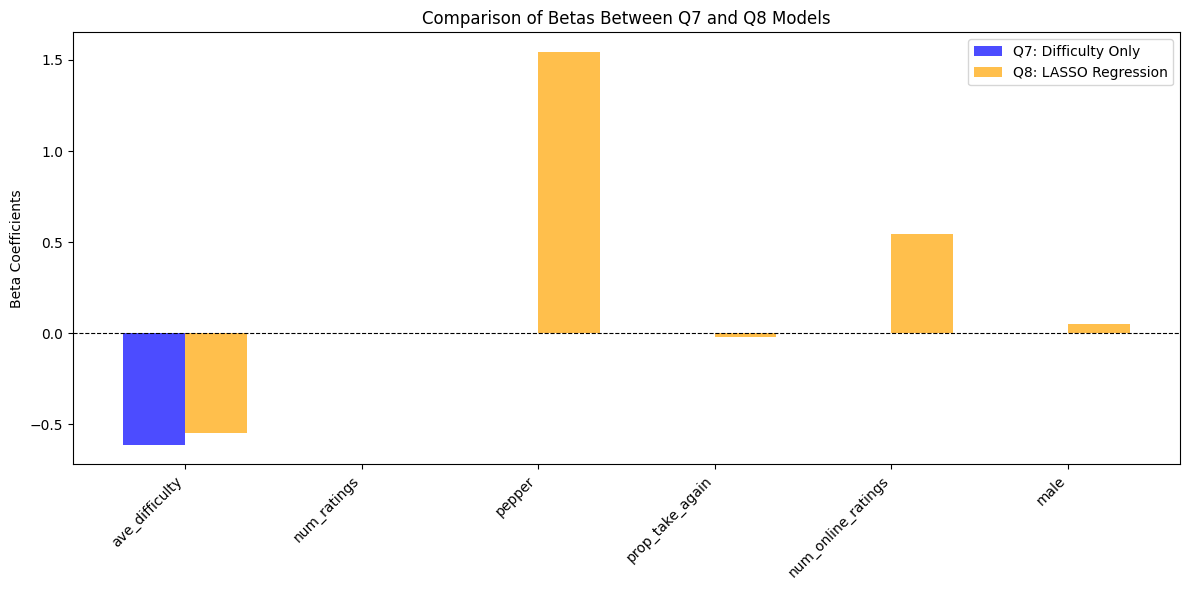

In [153]:
# Data for Question 7 (Difficulty Only Model)
q7_betas = [-0.6114]  # Coefficient for ave_difficulty only

# Data for Question 8 (LASSO Model)
q8_features = ["ave_difficulty", "num_ratings", "pepper", "prop_take_again", "num_online_ratings", "male"]
q8_betas = [-0.54771257, 0.00343446, 1.54348687, -0.02236517, 0.54490124, 0.05329159]  # Coefficients for all predictors

# Combine data for visualization
labels = ['ave_difficulty'] + q8_features[1:]  # Align labels
q7_betas_extended = q7_betas + [0] * (len(q8_betas) - len(q7_betas))  # Extend Q7 betas with 0s for comparison

# Bar plot comparison
x = np.arange(len(labels))  # Label positions

plt.figure(figsize=(12, 6))
bar_width = 0.35

# Plot Q7 betas
plt.bar(x - bar_width / 2, q7_betas_extended, bar_width, label='Q7: Difficulty Only', color='blue', alpha=0.7)

# Plot Q8 betas
plt.bar(x + bar_width / 2, q8_betas, bar_width, label='Q8: LASSO Regression', color='orange', alpha=0.7)

# Formatting the plot
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add horizontal line at 0
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Beta Coefficients')
plt.title('Comparison of Betas Between Q7 and Q8 Models')
plt.legend()
plt.tight_layout()
plt.show()



# Q9: To build a classification model that predicts whether a professor receives a 'pepper' (hotness) based on average rating only.

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.60      0.71     10086
         1.0       0.42      0.75      0.54      3915

    accuracy                           0.64     14001
   macro avg       0.64      0.68      0.62     14001
weighted avg       0.74      0.64      0.66     14001

ROC-AUC: 0.6992


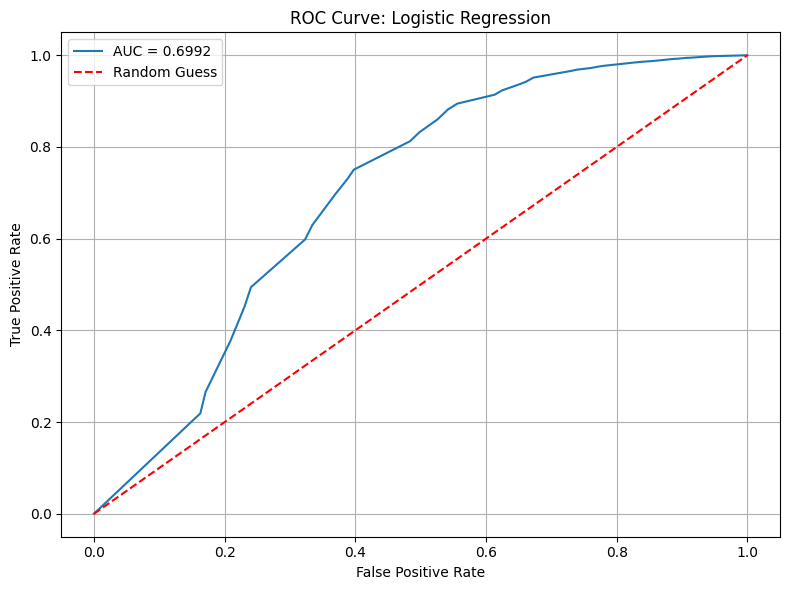

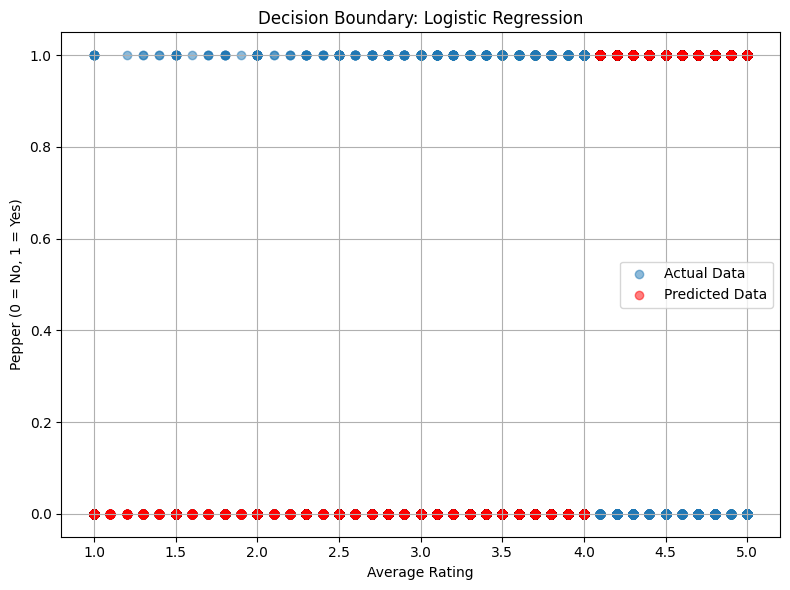

In [154]:
# Q9: To build a classification model that predicts whether a professor receives a "pepper" (hotness) based on average rating only.
print("\n# Q9: To build a classification model that predicts whether a professor receives a 'pepper' (hotness) based on average rating only.")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

# Prepare the Data
X = data[["ave_rating"]]  # Independent variable (IV)
y = data["pepper"].dropna()  # Dependent variable (DV)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12428625)  # N number as random seed

# Build Logistic Regression Model
log_reg = LogisticRegression(class_weight="balanced", random_state=12428625)  # Handle imbalance via class weights
log_reg.fit(X_train, y_train)

# Predict and Evaluate the Model
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Classification Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Decision Boundary Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, alpha=0.5, label="Actual Data")
plt.scatter(X_test, y_pred, alpha=0.5, color="red", label="Predicted Data")
plt.xlabel("Average Rating")
plt.ylabel("Pepper (0 = No, 1 = Yes)")
plt.title("Decision Boundary: Logistic Regression")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



# Q10: Build a classification model that predicts whether a professor receives a “pepper” from all available factors.

Classification Report (Full Model):
              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76      7519
         1.0       0.43      0.56      0.49      2899

    accuracy                           0.67     10418
   macro avg       0.62      0.64      0.62     10418
weighted avg       0.70      0.67      0.68     10418

ROC-AUC (Full Model): 0.7035


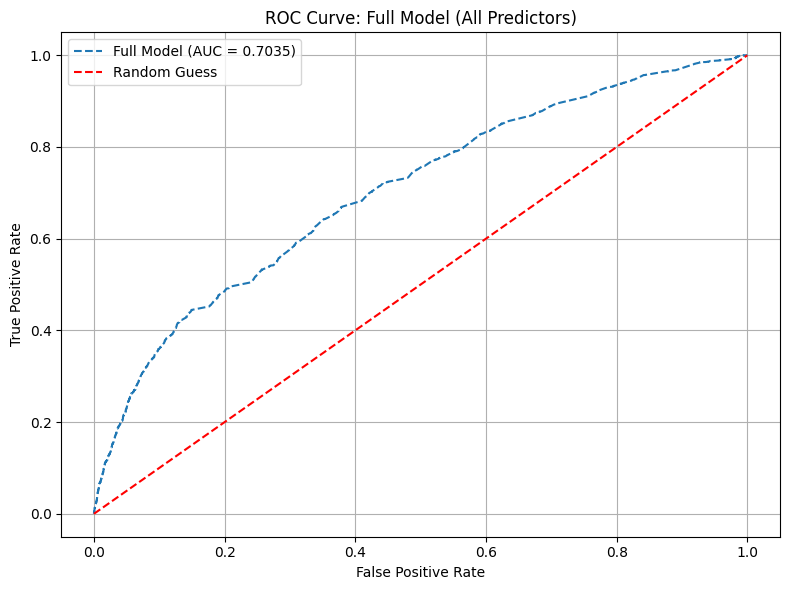


Interpretation:
- The classification report highlights precision, recall, and F1-scores for each class.
- The ROC-AUC score indicates the overall performance of the model in distinguishing between 'pepper' (1) and 'non-pepper' (0).


In [155]:
# Q10: Build a classification model that predicts whether a professor receives a “pepper” from all available factors.
print("\n# Q10: Build a classification model that predicts whether a professor receives a “pepper” from all available factors.")
# Data Preparation
# Drop rows with NaN values in binary categories
data_filtered = data.dropna(subset=["male", "female", "pepper"])

# Further filter: Drop rows where both 'male' and 'female' are 0 or both are 1
data_filtered = data_filtered[(data_filtered["male"] + data_filtered["female"] == 1)].copy()

# Define predictors: Drop 'female' to handle collinearity
predictors = ["ave_difficulty", "num_ratings", "prop_take_again", "num_online_ratings", "male"]
X_full = data_filtered[predictors]  # Predictors for the full model
y = data_filtered["pepper"]  # Target variable

# Train-Test Split (80% train, 20% test)
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=12428625)

# Build the Logistic Regression Model
# Use class_weight="balanced" to address class imbalance
log_reg_full = LogisticRegression(class_weight="balanced", random_state=12428625)
log_reg_full.fit(X_train_full, y_train)

# Predictions and Evaluation
# Predict class and probabilities
y_pred_full = log_reg_full.predict(X_test_full)
y_pred_prob_full = log_reg_full.predict_proba(X_test_full)[:, 1]

# Classification Report
print("\nClassification Report (Full Model):")
print(classification_report(y_test, y_pred_full))

# ROC-AUC Score
roc_auc_full = roc_auc_score(y_test, y_pred_prob_full)
print(f"ROC-AUC (Full Model): {roc_auc_full:.4f}")

# Plot ROC Curve
fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_prob_full)

plt.figure(figsize=(8, 6))
plt.plot(fpr_full, tpr_full, label=f"Full Model (AUC = {roc_auc_full:.4f})", linestyle="--")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Full Model (All Predictors)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Step 6: Interpret Results
print("\nInterpretation:")
print("- The classification report highlights precision, recall, and F1-scores for each class.")
print("- The ROC-AUC score indicates the overall performance of the model in distinguishing between 'pepper' (1) and 'non-pepper' (0).")



# Extra Credit: Identifying Popular and Unpopular Majors Based on Professors' Average Ratings.
Number of unique majors: 1272
Number of Professors in Each Major:
                                   major  avg_rating  professor_count
444                              English    3.946608             6398
856                          Mathematics    3.625661             5557
158                              Biology    3.654778             3328
1052                          Psychology    3.940182             3300
178                             Business    3.763825             2510
...                                  ...         ...              ...
662                Hospitality & Tourism    5.000000                1
666         Human  Community Development    5.000000                1
668   Human Centered Design  Engineering    4.800000                1
677       Human Evolution  Social Change    4.300000                1
636                    Health Technology    2.000000                

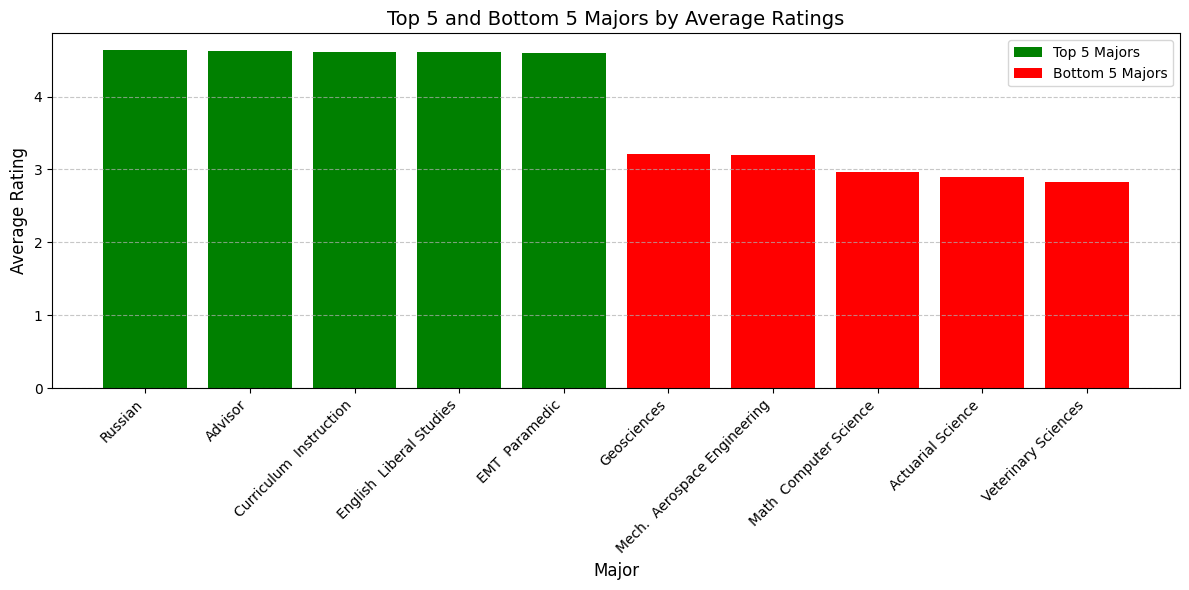

Top 5 Majors by Average Rating:
                         major  avg_rating  professor_count
1107                   Russian    4.635294               17
29                     Advisor    4.623810               21
347    Curriculum  Instruction    4.608333               12
447   English  Liberal Studies    4.605882               17
381             EMT  Paramedic    4.592857               14

Bottom 5 Majors by Average Rating:
                             major  avg_rating  professor_count
580                    Geosciences    3.207143               14
865   Mech.  Aerospace Engineering    3.200000               11
850         Math  Computer Science    2.966667                9
17               Actuarial Science    2.900000               13
1236           Veterinary Sciences    2.833333                9


In [156]:
# Extra Credit: Identifying Popular and Unpopular Majors Based on Professors' Average Ratings.
print("\n# Extra Credit: Identifying Popular and Unpopular Majors Based on Professors' Average Ratings.")
# Data Preparation
# Group the data by 'major' and calculate the average rating and professor count for each major
major_stats = data.groupby('major').agg(
    avg_rating=('ave_rating', 'mean'),  # Average rating for each major
    professor_count=('ave_rating', 'count')  # Number of professors in each major
).reset_index()

# Sort the results by the number of professors (descending order)
professor_count_by_major = major_stats.sort_values('professor_count', ascending=False)

# Count the number of unique majors
unique_majors_count = data['major'].nunique()
print(f"Number of unique majors: {unique_majors_count}")

# Print the number of professors for each major
print("Number of Professors in Each Major:")
print(professor_count_by_major)

# Compute Descriptive Statistics for Professor Counts
# Calculate descriptive statistics for the professor count per major
professor_counts = data['major'].value_counts()  # Count the number of professors for each major
descriptive_stats = professor_counts.describe()  # Descriptive statistics for the counts
print("\nDescriptive Statistics for Professors Count by Major:")
print(descriptive_stats)

# Count Majors with Fewer than 9 Professors
# Filter majors with fewer than 9 professors and count them
majors_with_fewer_than_9 = professor_counts[professor_counts < 9].count()
print(f"Number of majors with fewer than 9 professors: {majors_with_fewer_than_9}")

# Filter Majors with At Least 9 Professors
# Exclude majors with fewer than 9 professors for further analysis
filtered_major_stats = major_stats[major_stats['professor_count'] >= 9]

# Sort the remaining majors by average rating (descending order)
sorted_majors = filtered_major_stats.sort_values('avg_rating', ascending=False)

# Visualize Top 5 and Bottom 5 Majors by Average Ratings
plt.figure(figsize=(12, 6))

# Extract the top 5 majors by average rating
top_5_majors = sorted_majors.head(5)
plt.bar(top_5_majors['major'], top_5_majors['avg_rating'], color='green', label='Top 5 Majors')

# Extract the bottom 5 majors by average rating
bottom_5_majors = sorted_majors.tail(5)
plt.bar(bottom_5_majors['major'], bottom_5_majors['avg_rating'], color='red', label='Bottom 5 Majors')

# Add labels, title, and legend to the plot
plt.title('Top 5 and Bottom 5 Majors by Average Ratings', fontsize=14)
plt.ylabel('Average Rating', fontsize=12)
plt.xlabel('Major', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print Detailed Results
# Display the top 5 and bottom 5 majors with their average ratings and professor counts
print("Top 5 Majors by Average Rating:")
print(top_5_majors[['major', 'avg_rating', 'professor_count']])

print("\nBottom 5 Majors by Average Rating:")
print(bottom_5_majors[['major', 'avg_rating', 'professor_count']])



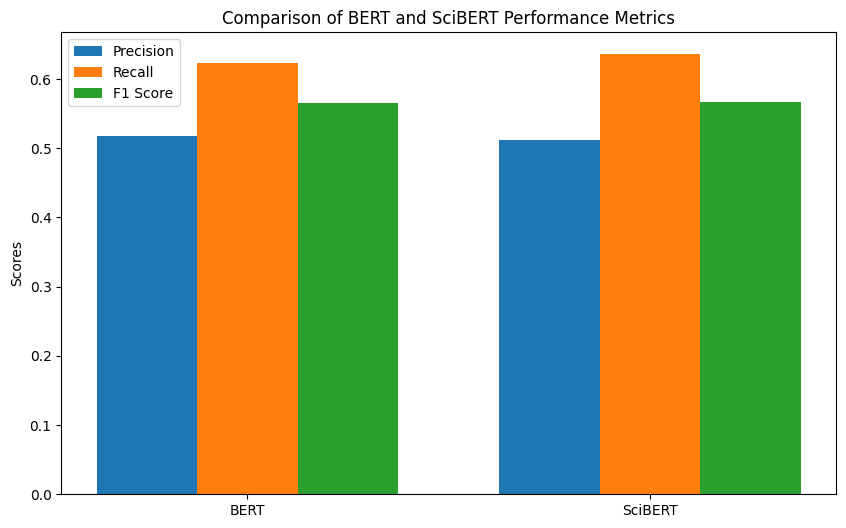

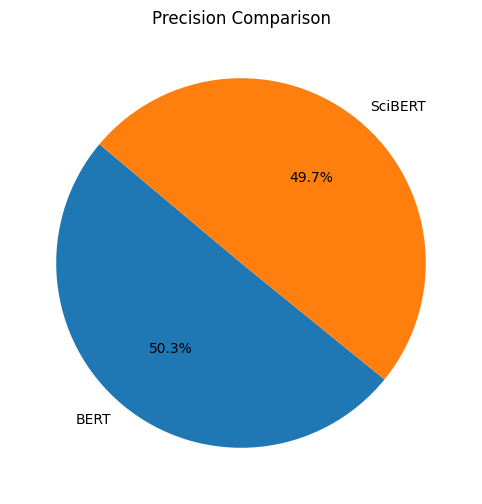

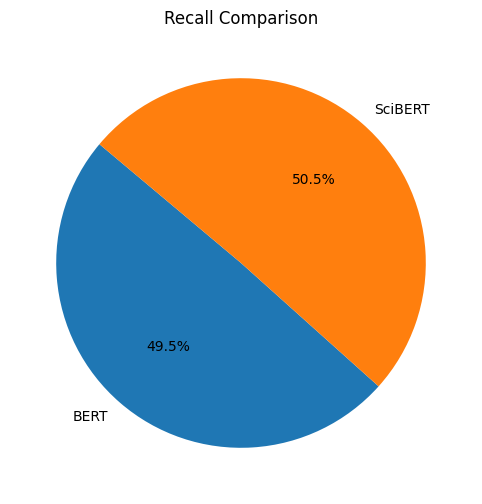

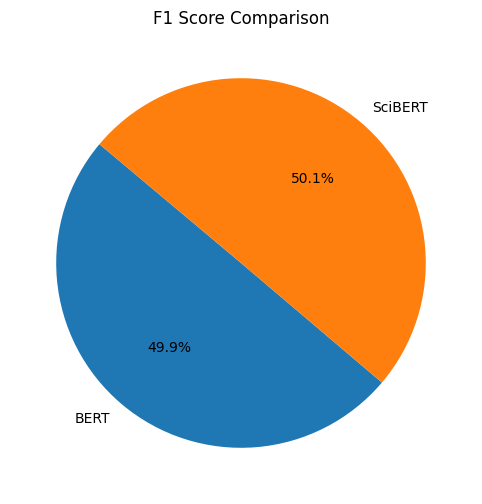

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['BERT', 'SciBERT']
precision = [0.5175, 0.5122]
recall = [0.6227, 0.6358]
f1_score = [0.5653, 0.5673]

# Setting the positions and width for the bars
positions = np.arange(len(models))
width = 0.25

# Plotting bar plots for Precision, Recall, and F1 Score
plt.figure(figsize=(10, 6))
plt.bar(positions - width, precision, width, label='Precision')
plt.bar(positions, recall, width, label='Recall')
plt.bar(positions + width, f1_score, width, label='F1 Score')

plt.xticks(positions, models)
plt.ylabel('Scores')
plt.title('Comparison of BERT and SciBERT Performance Metrics')
plt.legend()

plt.show()

# Plotting pie plots for Precision, Recall, and F1 Score
def plot_pie_chart(values, title, labels):
    plt.figure(figsize=(8, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

# Pie plots for each model
plot_pie_chart(precision, 'Precision Comparison', models)
plot_pie_chart(recall, 'Recall Comparison', models)
plot_pie_chart(f1_score, 'F1 Score Comparison', models)


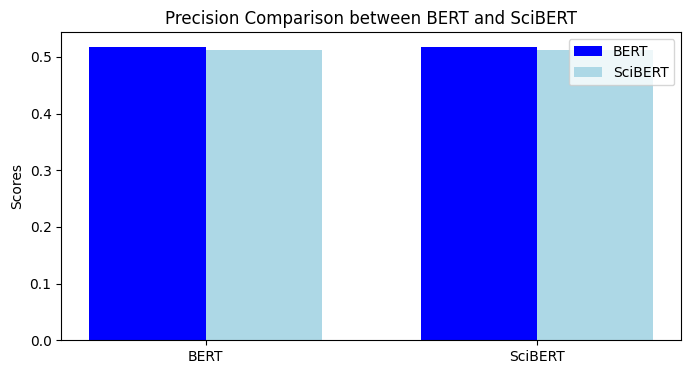

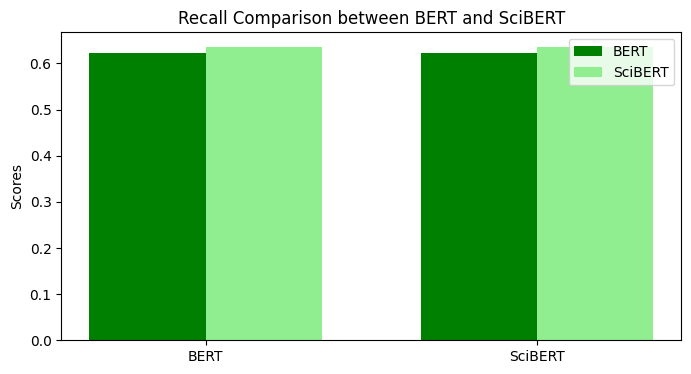

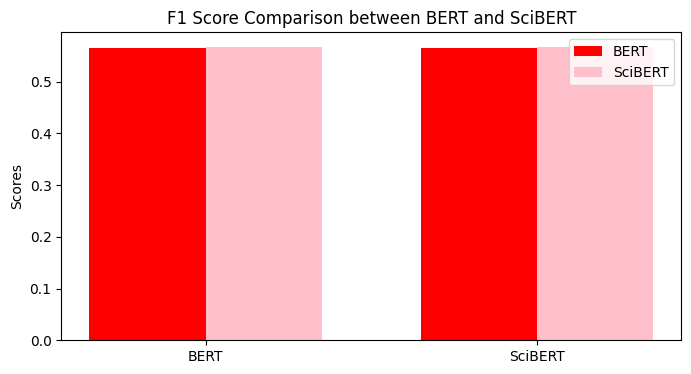

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
models = ['BERT', 'SciBERT']
precision = [0.5175, 0.5122]
recall = [0.6227, 0.6358]
f1_score = [0.5653, 0.5673]
metrics = [precision, recall, f1_score]
metric_labels = ['Precision', 'Recall', 'F1 Score']

# 设置颜色
colors = [['blue', 'lightblue'], ['green', 'lightgreen'], ['red', 'pink']]

# 绘制柱状图对比
def plot_bar_comparison(metric_values, metric_label, color_pair):
    x = np.arange(len(models))  # 模型数量
    width = 0.35  # 柱体宽度

    plt.figure(figsize=(8, 4))
    plt.bar(x - width/2, metric_values[0], width, label=models[0], color=color_pair[0])
    plt.bar(x + width/2, metric_values[1], width, label=models[1], color=color_pair[1])

    plt.ylabel('Scores')
    plt.title(f'{metric_label} Comparison between BERT and SciBERT')
    plt.xticks(x, models)
    plt.legend()
    plt.show()

# 为每个度量绘制图表
for i, metric in enumerate(metrics):
    plot_bar_comparison(metric, metric_labels[i], colors[i])


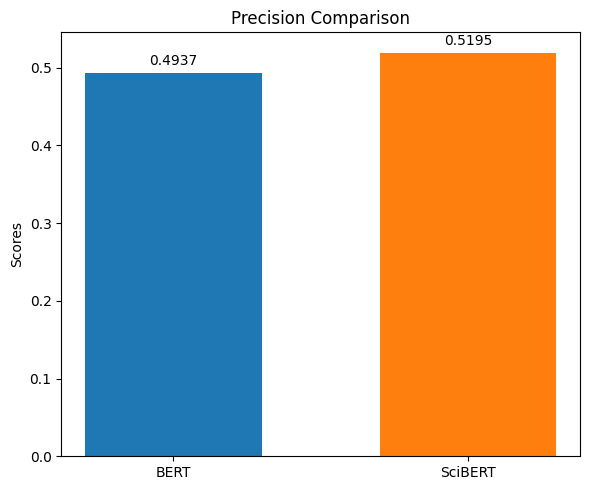

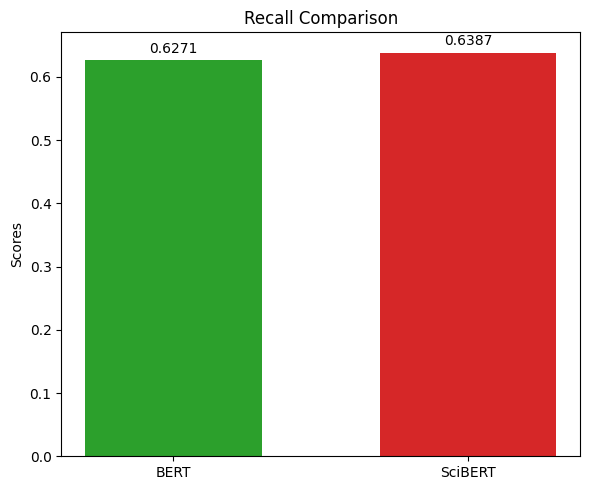

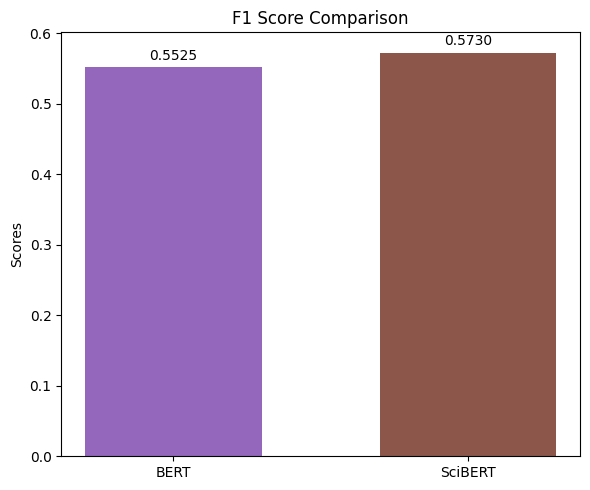

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['BERT', 'SciBERT']
precision = [0.4937, 0.5195]
recall = [0.6271, 0.6387]
f1_score = [0.5525, 0.5730]
metrics = [precision, recall, f1_score]
metric_labels = ['Precision', 'Recall', 'F1 Score']

# Colors for each metric
metric_colors = [['#1f77b4', '#ff7f0e'],  # Precision: Blue, Orange
                 ['#2ca02c', '#d62728'],  # Recall: Green, Red
                 ['#9467bd', '#8c564b']]  # F1 Score: Purple, Brown

# Function to plot a single graph
def plot_single_metric(metric_values, metric_label, colors):
    fig, ax = plt.subplots(figsize=(6, 5))  # Set figure size
    
    # X-axis setup: two bars for BERT and SciBERT
    x = np.arange(len(models))  # Two positions
    
    # Plot bars with two different colors
    bars = ax.bar(x, metric_values, color=colors, width=0.6)
    
    # Title and labels
    ax.set_title(f'{metric_label} Comparison')
    ax.set_ylabel('Scores')
    ax.set_xticks(x)
    ax.set_xticklabels(models)

    # Annotate values on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Generate a graph for each metric
for i, metric in enumerate(metrics):
    plot_single_metric(metric, metric_labels[i], metric_colors[i])




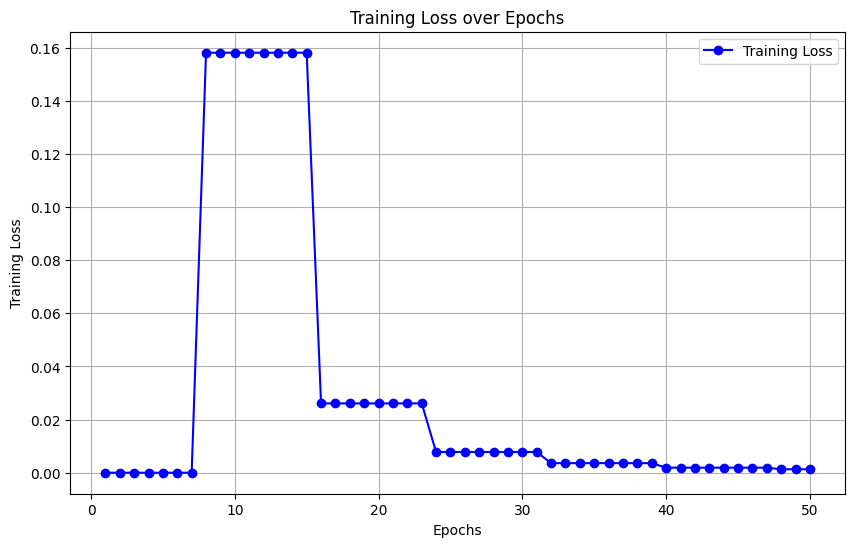

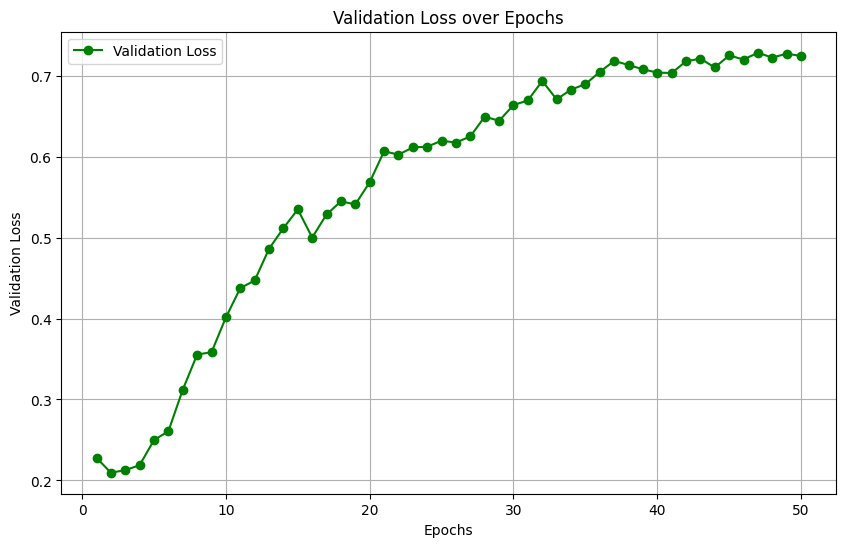

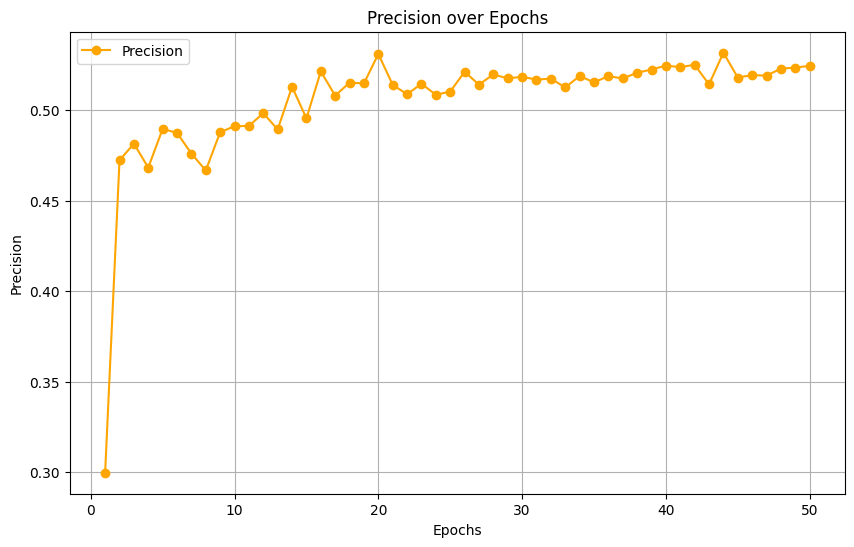

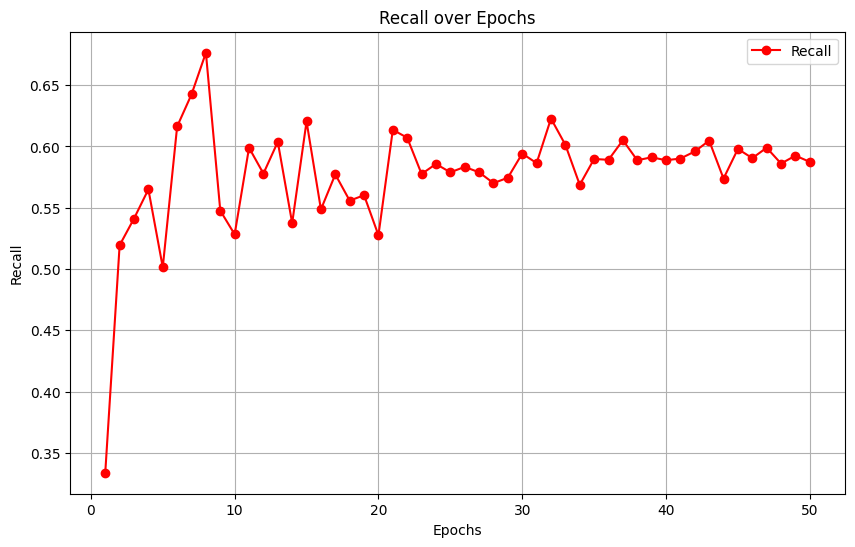

In [13]:
import matplotlib.pyplot as plt

# 数据（将 "No log" 处理为 0.0）
epochs = list(range(1, 51))
training_loss = [0.0] * 7 + [0.158100] * 8 + [0.026100] * 8 + [0.007800] * 8 + [0.003600] * 8 + [0.001900] * 8 + [0.001300]*3
validation_loss = [0.227929, 0.209483, 0.212691, 0.218812, 0.249908, 0.260749, 0.312173, 0.355558, 0.358446, 0.401523, 
                   0.437639, 0.447094, 0.486235, 0.511804, 0.534986, 0.500194, 0.528737, 0.544870, 0.541173, 0.568462, 
                   0.606827, 0.602659, 0.611492, 0.612538, 0.619805, 0.617600, 0.625147, 0.649583, 0.644450, 0.663924, 
                   0.669630, 0.693773, 0.670932, 0.683003, 0.689719, 0.704881, 0.718389, 0.713508, 0.708033, 0.704101, 
                   0.703504, 0.717970, 0.721342, 0.710353, 0.725280, 0.720196, 0.728602, 0.722565, 0.727449, 0.724527]
precision = [0.299573, 0.472334, 0.481549, 0.468301, 0.489708, 0.487497, 0.476071, 0.466698, 0.487886, 0.491150,
             0.491355, 0.498388, 0.489391, 0.512979, 0.495520, 0.521486, 0.508079, 0.515285, 0.514839, 0.531143, 
             0.514099, 0.508832, 0.514693, 0.508560, 0.510339, 0.521264, 0.514191, 0.519839, 0.517611, 0.518540, 
             0.516931, 0.517514, 0.512605, 0.518921, 0.515449, 0.518862, 0.517592, 0.520746, 0.522536, 0.524689, 
             0.523838, 0.525165, 0.514310, 0.531821, 0.518115, 0.519438, 0.519151, 0.523058, 0.523581, 0.524590]
recall = [0.333787, 0.519375, 0.541128, 0.564922, 0.501360, 0.616247, 0.642420, 0.676411, 0.547587, 0.528212, 
          0.598912, 0.577838, 0.603671, 0.537390, 0.620326, 0.548606, 0.577158, 0.555744, 0.560163, 0.527532, 
          0.613528, 0.607070, 0.577498, 0.585656, 0.578858, 0.583277, 0.578858, 0.570020, 0.574439, 0.594154, 
          0.586336, 0.622706, 0.601292, 0.568661, 0.589735, 0.589055, 0.605031, 0.588715, 0.591094, 0.588715, 
          0.590075, 0.595853, 0.604691, 0.573759, 0.597893, 0.590415, 0.598912, 0.585996, 0.592454, 0.587356]

# 绘图函数
def plot_metric(epochs, values, title, ylabel, color):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, values, marker='o', linestyle='-', color=color, label=ylabel)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

# 绘制每个指标的折线图
plot_metric(epochs, training_loss, 'Training Loss over Epochs', 'Training Loss', 'blue')
plot_metric(epochs, validation_loss, 'Validation Loss over Epochs', 'Validation Loss', 'green')
plot_metric(epochs, precision, 'Precision over Epochs', 'Precision', 'orange')
plot_metric(epochs, recall, 'Recall over Epochs', 'Recall', 'red')



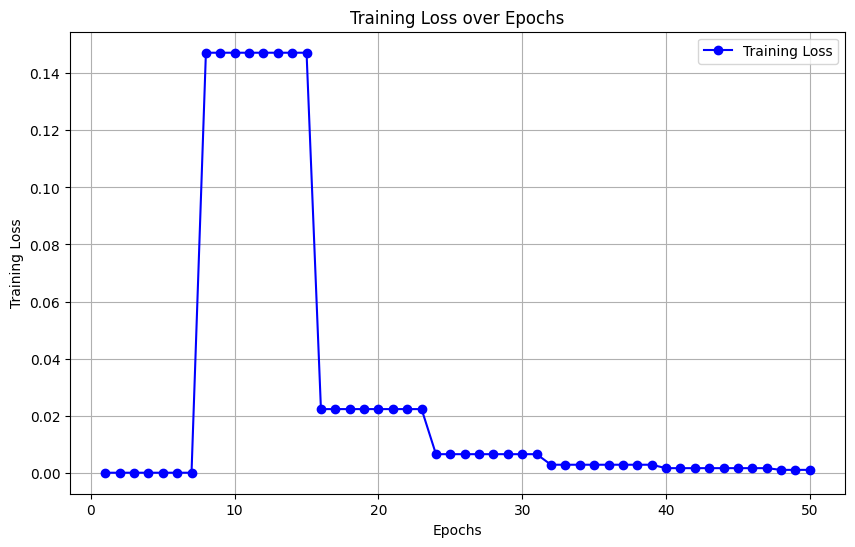

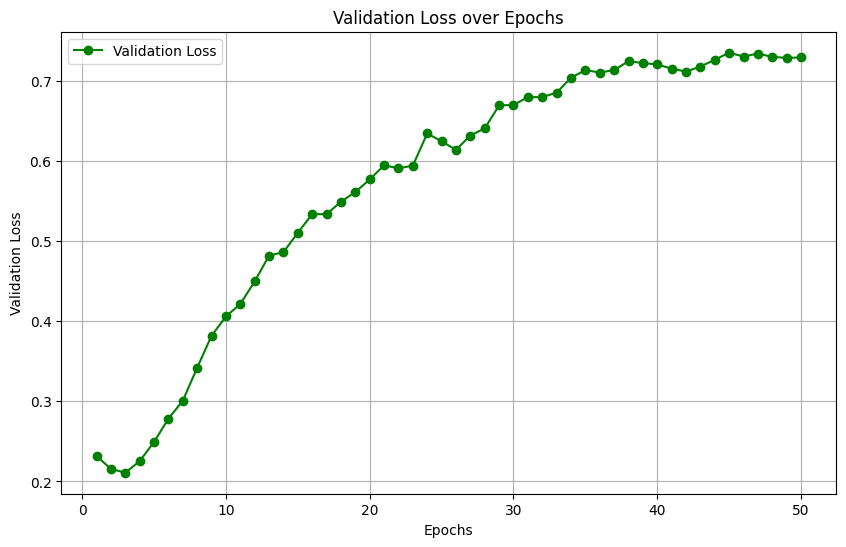

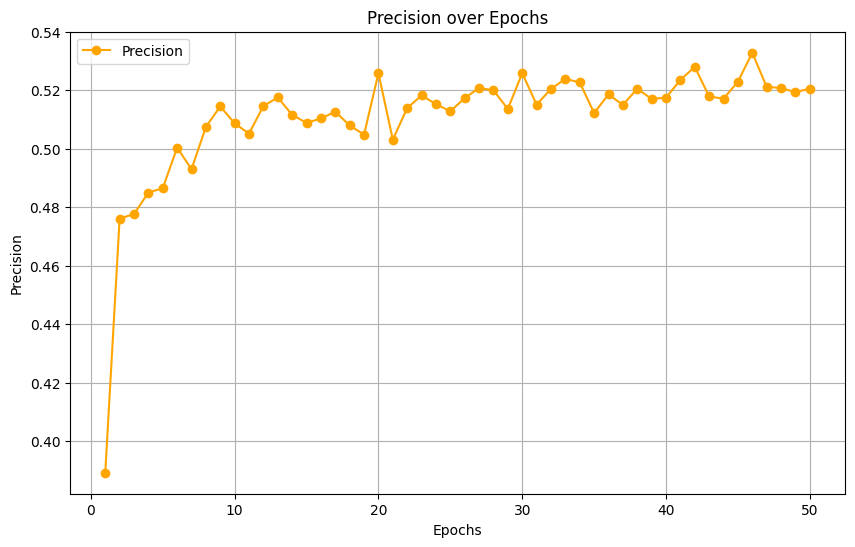

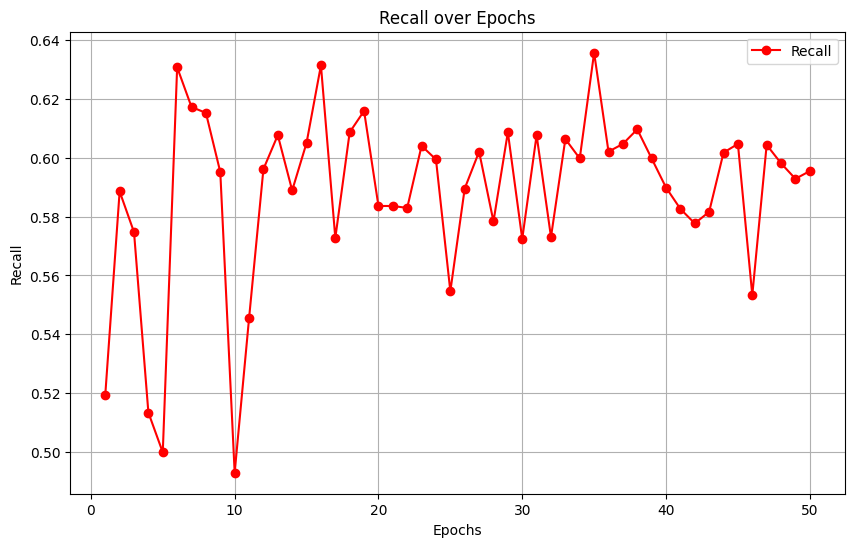

In [14]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 51))
training_loss = [0.0] * 7 + [0.147200] * 8 + [0.022300] * 8 + [0.006500] * 8 + [0.002800] * 8 + [0.001600] * 8 + [0.001000] * 3
validation_loss = [
    0.231682, 0.215704, 0.210859, 0.225298, 0.249236, 0.278251, 0.300677, 0.341812, 0.381731, 0.405843,
    0.421374, 0.449514, 0.481804, 0.486098, 0.510240, 0.533560, 0.533494, 0.549019, 0.561109, 0.576826,
    0.594443, 0.590774, 0.594054, 0.634176, 0.624456, 0.613782, 0.631633, 0.640603, 0.669202, 0.669823,
    0.679458, 0.679680, 0.685118, 0.703765, 0.713254, 0.710284, 0.713244, 0.724399, 0.722075, 0.720314,
    0.715130, 0.711396, 0.717721, 0.726208, 0.734971, 0.730248, 0.733860, 0.729803, 0.728516, 0.729106
]
precision = [
    0.389122, 0.476114, 0.477653, 0.485037, 0.486513, 0.500393, 0.493017, 0.507483, 0.514546, 0.508682,
    0.505196, 0.514668, 0.517561, 0.511608, 0.508879, 0.510400, 0.512699, 0.507985, 0.504867, 0.525862,
    0.503129, 0.513962, 0.518256, 0.515315, 0.512813, 0.517371, 0.520833, 0.520024, 0.513641, 0.525917,
    0.515101, 0.520527, 0.523945, 0.522714, 0.512228, 0.518613, 0.515032, 0.520563, 0.517065, 0.517511,
    0.523570, 0.528046, 0.517920, 0.517153, 0.522967, 0.532888, 0.521195, 0.520827, 0.519364, 0.520623
]
recall = [
    0.519301, 0.588585, 0.574728, 0.513362, 0.499835, 0.630815, 0.617288, 0.615308, 0.595183, 0.492907,
    0.545365, 0.596173, 0.607720, 0.588915, 0.605081, 0.631475, 0.572748, 0.608710, 0.615968, 0.583636,
    0.583636, 0.582976, 0.604091, 0.599472, 0.554602, 0.589574, 0.602112, 0.578357, 0.608710, 0.572418,
    0.607720, 0.573078, 0.606401, 0.599802, 0.635764, 0.602112, 0.604751, 0.609700, 0.599802, 0.589904,
    0.582646, 0.577697, 0.581656, 0.601782, 0.604751, 0.553283, 0.604421, 0.598152, 0.592874, 0.595513
]

# Plot function
def plot_metric(epochs, values, title, ylabel, color):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, values, marker='o', linestyle='-', color=color, label=ylabel)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

# Generate line plots for each metric
plot_metric(epochs, training_loss, 'Training Loss over Epochs', 'Training Loss', 'blue')
plot_metric(epochs, validation_loss, 'Validation Loss over Epochs', 'Validation Loss', 'green')
plot_metric(epochs, precision, 'Precision over Epochs', 'Precision', 'orange')
plot_metric(epochs, recall, 'Recall over Epochs', 'Recall', 'red')


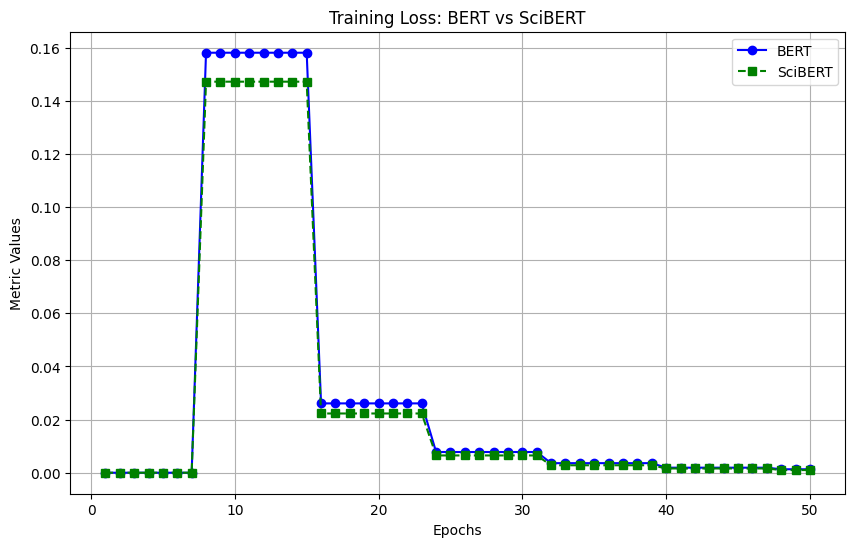

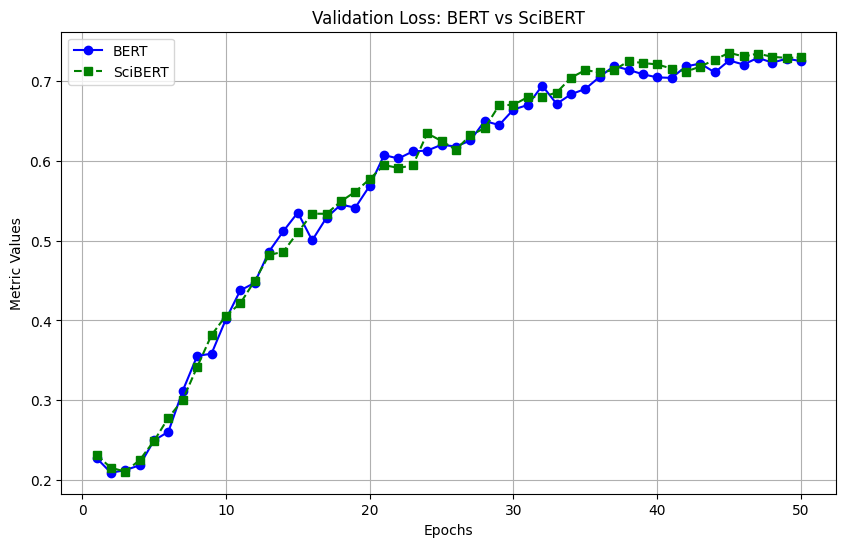

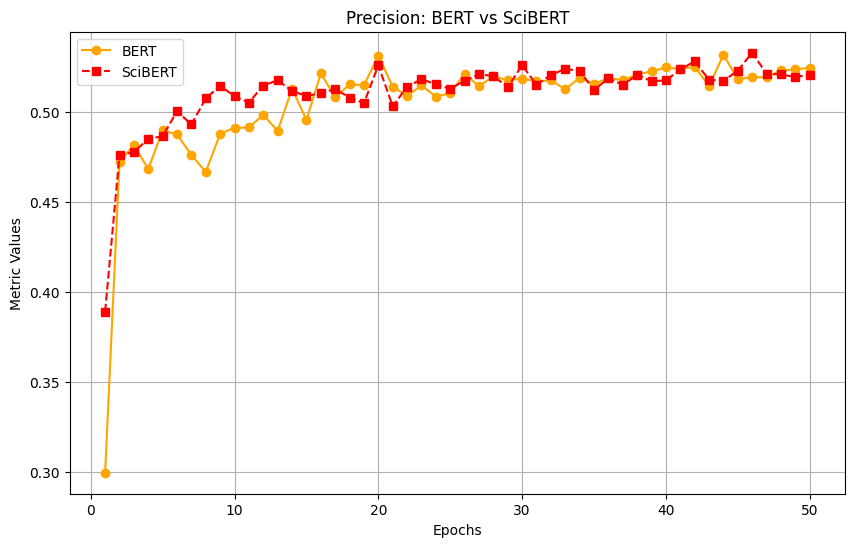

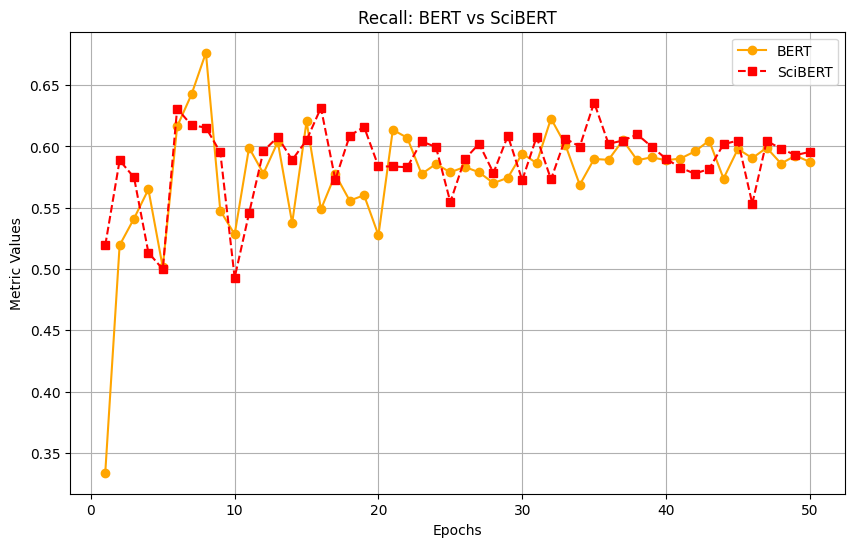

In [15]:
import matplotlib.pyplot as plt

# Define epochs
epochs = list(range(1, 51))

# First set of data (BERT)
bert_training_loss = [0.0] * 7 + [0.158100] * 8 + [0.026100] * 8 + [0.007800] * 8 + [0.003600] * 8 + [0.001900] * 8 + [0.001300] * 3
bert_validation_loss = [0.227929, 0.209483, 0.212691, 0.218812, 0.249908, 0.260749, 0.312173, 0.355558, 0.358446, 0.401523,
                        0.437639, 0.447094, 0.486235, 0.511804, 0.534986, 0.500194, 0.528737, 0.544870, 0.541173, 0.568462,
                        0.606827, 0.602659, 0.611492, 0.612538, 0.619805, 0.617600, 0.625147, 0.649583, 0.644450, 0.663924,
                        0.669630, 0.693773, 0.670932, 0.683003, 0.689719, 0.704881, 0.718389, 0.713508, 0.708033, 0.704101,
                        0.703504, 0.717970, 0.721342, 0.710353, 0.725280, 0.720196, 0.728602, 0.722565, 0.727449, 0.724527]
bert_precision = [0.299573, 0.472334, 0.481549, 0.468301, 0.489708, 0.487497, 0.476071, 0.466698, 0.487886, 0.491150,
                  0.491355, 0.498388, 0.489391, 0.512979, 0.495520, 0.521486, 0.508079, 0.515285, 0.514839, 0.531143,
                  0.514099, 0.508832, 0.514693, 0.508560, 0.510339, 0.521264, 0.514191, 0.519839, 0.517611, 0.518540,
                  0.516931, 0.517514, 0.512605, 0.518921, 0.515449, 0.518862, 0.517592, 0.520746, 0.522536, 0.524689,
                  0.523838, 0.525165, 0.514310, 0.531821, 0.518115, 0.519438, 0.519151, 0.523058, 0.523581, 0.524590]
bert_recall = [0.333787, 0.519375, 0.541128, 0.564922, 0.501360, 0.616247, 0.642420, 0.676411, 0.547587, 0.528212,
               0.598912, 0.577838, 0.603671, 0.537390, 0.620326, 0.548606, 0.577158, 0.555744, 0.560163, 0.527532,
               0.613528, 0.607070, 0.577498, 0.585656, 0.578858, 0.583277, 0.578858, 0.570020, 0.574439, 0.594154,
               0.586336, 0.622706, 0.601292, 0.568661, 0.589735, 0.589055, 0.605031, 0.588715, 0.591094, 0.588715,
               0.590075, 0.595853, 0.604691, 0.573759, 0.597893, 0.590415, 0.598912, 0.585996, 0.592454, 0.587356]

# Second set of data (SciBERT)
scibert_training_loss = [0.0] * 7 + [0.147200] * 8 + [0.022300] * 8 + [0.006500] * 8 + [0.002800] * 8 + [0.001600] * 8 + [0.001000] * 3
scibert_validation_loss = [0.231682, 0.215704, 0.210859, 0.225298, 0.249236, 0.278251, 0.300677, 0.341812, 0.381731, 0.405843,
                           0.421374, 0.449514, 0.481804, 0.486098, 0.510240, 0.533560, 0.533494, 0.549019, 0.561109, 0.576826,
                           0.594443, 0.590774, 0.594054, 0.634176, 0.624456, 0.613782, 0.631633, 0.640603, 0.669202, 0.669823,
                           0.679458, 0.679680, 0.685118, 0.703765, 0.713254, 0.710284, 0.713244, 0.724399, 0.722075, 0.720314,
                           0.715130, 0.711396, 0.717721, 0.726208, 0.734971, 0.730248, 0.733860, 0.729803, 0.728516, 0.729106]
scibert_precision = [0.389122, 0.476114, 0.477653, 0.485037, 0.486513, 0.500393, 0.493017, 0.507483, 0.514546, 0.508682,
                     0.505196, 0.514668, 0.517561, 0.511608, 0.508879, 0.510400, 0.512699, 0.507985, 0.504867, 0.525862,
                     0.503129, 0.513962, 0.518256, 0.515315, 0.512813, 0.517371, 0.520833, 0.520024, 0.513641, 0.525917,
                     0.515101, 0.520527, 0.523945, 0.522714, 0.512228, 0.518613, 0.515032, 0.520563, 0.517065, 0.517511,
                     0.523570, 0.528046, 0.517920, 0.517153, 0.522967, 0.532888, 0.521195, 0.520827, 0.519364, 0.520623]
scibert_recall = [0.519301, 0.588585, 0.574728, 0.513362, 0.499835, 0.630815, 0.617288, 0.615308, 0.595183, 0.492907,
                  0.545365, 0.596173, 0.607720, 0.588915, 0.605081, 0.631475, 0.572748, 0.608710, 0.615968, 0.583636,
                  0.583636, 0.582976, 0.604091, 0.599472, 0.554602, 0.589574, 0.602112, 0.578357, 0.608710, 0.572418,
                  0.607720, 0.573078, 0.606401, 0.599802, 0.635764, 0.602112, 0.604751, 0.609700, 0.599802, 0.589904,
                  0.582646, 0.577697, 0.581656, 0.601782, 0.604751, 0.553283, 0.604421, 0.598152, 0.592874, 0.595513]

# Function to plot comparison for the same metric
def plot_comparison(epochs, values1, values2, title, label1, label2, color1, color2):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, values1, marker='o', linestyle='-', color=color1, label=label1)
    plt.plot(epochs, values2, marker='s', linestyle='--', color=color2, label=label2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Metric Values')
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot comparisons
plot_comparison(epochs, bert_training_loss, scibert_training_loss,
                'Training Loss: BERT vs SciBERT', 'BERT', 'SciBERT', 'blue', 'green')
plot_comparison(epochs, bert_validation_loss, scibert_validation_loss,
                'Validation Loss: BERT vs SciBERT', 'BERT', 'SciBERT', 'blue', 'green')
plot_comparison(epochs, bert_precision, scibert_precision,
                'Precision: BERT vs SciBERT', 'BERT', 'SciBERT', 'orange', 'red')
plot_comparison(epochs, bert_recall, scibert_recall,
                'Recall: BERT vs SciBERT', 'BERT', 'SciBERT', 'orange', 'red')
